In [1]:
import os
import json
from gspread import Client
from authlib.integrations.requests_client import AssertionSession

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_credentials():
    home = os.path.expanduser("~")
    cred_file = "weight-loss-track-2020-fbc41f7c95b2.json"
    with open(f"{home}/keys/google/{cred_file}", "r") as f:
        credentials = json.load(f)
    return credentials

def create_assertion_session(scopes, subject=None):
    credentials = get_credentials()
    token_endpoint = credentials['token_uri']
    issuer = credentials['client_email']
    private_key = credentials['private_key']
    key_id = credentials.get('private_key_id')

    header = {'alg': 'RS256'}
    if key_id is not None:
        header['kid'] = key_id

    claims = {'scope': ' '.join(scopes)}
    return AssertionSession(
        grant_type=AssertionSession.JWT_BEARER_GRANT_TYPE,
        token_endpoint=token_endpoint,
        issuer=issuer,
        audience=token_endpoint,
        claims=claims,
        subject=subject,
        key=private_key,
        header=header,
    )

def get_weight_data():
    scopes = [
    'https://spreadsheets.google.com/feeds',
    'https://www.googleapis.com/auth/drive',
    ]
    session = create_assertion_session(scopes)
    gc = Client(None, session)
    weight_track_spreadsheet = gc.open("weight-track").sheet1
    return weight_track_spreadsheet.get_all_records()

def process_weight_data(data: list):
    df = pd.DataFrame(weight_data)
    df.rename(columns={'Timestamp': 'timestamp',
                       'Weight (KG)': 'weight',
                       'Loss (KG)': 'loss'},
              inplace=True)
    df.drop('Datetime', inplace=True, axis='columns')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df['time'] = df['timestamp'].dt.time
    df['5-pt-MA'] = df['loss'].rolling(5).mean()
    return df

def time_dist_plot(df):
    plt.figure(figsize=(12, 6))
    sns.distplot(df['timestamp'].dt.hour + df['timestamp'].dt.minute/60, bins=8)
    
def weight_loss_plot(df):
    plt.figure(figsize=(15, 6))
    plt.style.use('fivethirtyeight')
    plt.plot(df['timestamp'], df['loss'],
             label='Loss (KG)', marker="o", markersize=10)
    plt.plot(df['timestamp'], df['5-pt-MA'], alpha=0.4, label='5 pt MA')
    plt.legend(bbox_to_anchor = [0.98, 0.2])
    curr_loss = df.iloc[-1]['loss']
    plt.hlines(curr_loss,
               xmin=df['timestamp'].min(),
               xmax=df['timestamp'].max(),
               linewidth=2.5,
               colors='grey',
               linestyles='--',
               label=str(curr_loss))
    plt.text(x=df['timestamp'].max(),
             y=curr_loss*1.03,
             s=f"{curr_loss}",
             weight='bold');
    plt.title(f"Total weighings: {len(df)}")
    plt.xticks(rotation=30)
    plt.show()

In [3]:
weight_data = get_weight_data()
df = process_weight_data(weight_data)

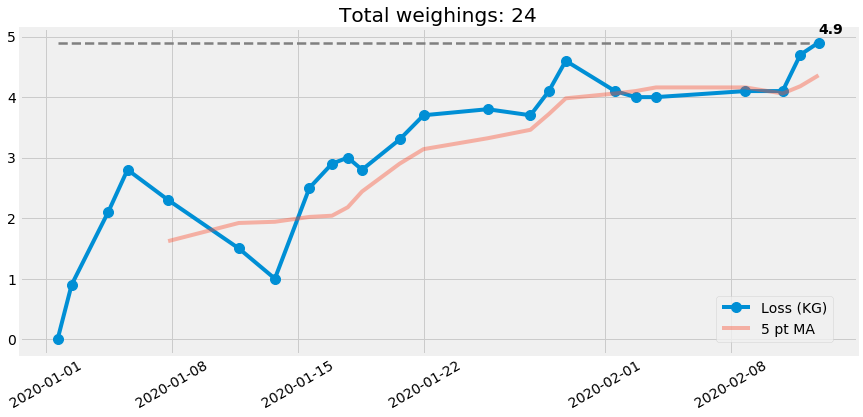

In [4]:
weight_loss_plot(df)